# 8. Convolutional neural network

You tested above different models with the set of high-level features extracted from a pretrained neural network. However, can you get similar results by creating a ConvNet from scratch and using the pixel values from the original images to train the model?

First, we reimport libraries, arrays and list we are going to use for this section (from previous notebook)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')
from zipfile import ZipFile
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
# Define file path
zip_path = "swissroads.zip"

# Extract from archive
with ZipFile(zip_path, 'r') as zip:
    zip.extractall()

# Create image generator for training with image transformation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=.1,
    height_shift_range=.1,
    zoom_range=0.3,
    horizontal_flip=True
)

train_set = train_datagen.flow_from_directory(    
    'train',
    batch_size=64,
    shuffle=True,
    class_mode='sparse'
)

test_datagen = ImageDataGenerator(rescale=1./255)

valid_set = test_datagen.flow_from_directory(
    'valid',
    shuffle=False,
    class_mode='sparse'
)

test_set = test_datagen.flow_from_directory(
    'test',
    shuffle=False,
    class_mode='sparse'
)

Found 281 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 55 images belonging to 6 classes.


## Test architecture : Reproducing VGGNet
I chose to reproduce VGGNet presented [here](https://youtu.be/u6aEYuemt0M?t=2419) as it is praised for its 'simplicity' and i think makes up for a good model to reproduce as it is intelligible. Image is from [here](https://miro.medium.com/max/850/1*B_ZaaaBg2njhp8SThjCufA.png)

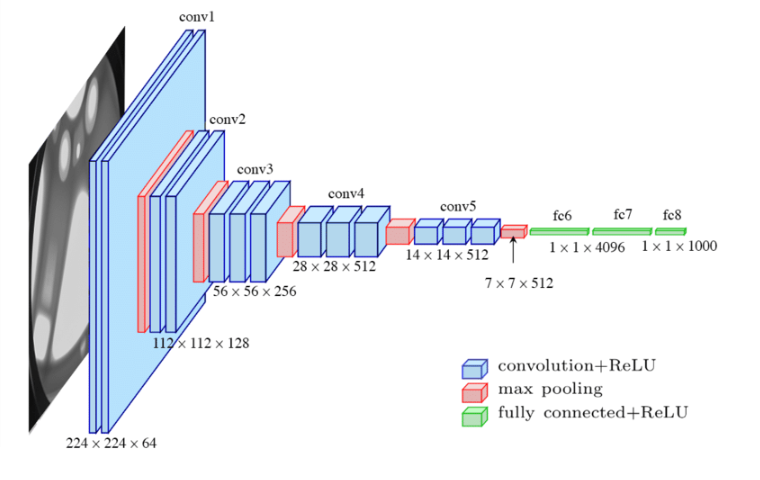

At first we tried the full architecture but computational time was too long, so we switched to a simpler version, still keeping the 64 > 128 > 256 > 512 kernels logic.

## Simplified Architecture 

- INPUT: [224x224x3]
- CONV3-64 + ReLU: [224x224x64]
- POOL2: [112x112x64]
- CONV3-128 + ReLU: [112x112x128]
- POOL2: [56x56x128]
- CONV3-256 + ReLU: [56x56x256]
- POOL2: [28x28x256]
- CONV3-512 + ReLU: [28x28x512]
- POOL2: [7x7x512]
- Fully Connect + ReLU : [1x1x4096]

The size of the Dense layer was a parameter we tweaked but we saw better performance with 4096 than 2048, so chose to stay at 4096.

## Tweaking strides in Convolutional Layers

Initially, we set the strides parameter of the convolutional layers to 1, which means that filter moved one pixel at a time over the input image. Computational time for each epoch was higher, around 55s per epoch, and model started overfitting the training data after only 10 epochs.

This was likely due to a large number of parameters,caused by the small stride and resulting in larger output feature maps. To address this issue, we changed strides parameter to 2, reducing size of the output feature maps and number of parameters. It helped against overfitting and improved computational time, each epoch being now around 5s.

## Changing parameters in Data augmentation

After running a few iteration, overfitting was still a problem so we played with parameters in ImageDataGenerator as to diversify images in train_set and also increase batch_size from 32 to 64 to introduce more diversity. 
- rotation_range=30,
- width_shift_range=.1
- height_shift_range=.1
- zoom_range=0.3

We found best performance with the above parameters, but it is very possible a other combination or fewer parameters could achieve same or better performance. It is hard to say without computational power to try out all possible combinations as in with GridSearchCV.

## Other tweaks to fit over/under fitting

At this stage we tried increasing slightly also dropout rate and strength of regularization. Our final proposal has stronger regularization out of the convolutional layers and a dropout layer before applying softmax for classification. In iteration, we tried two dropout layers and/or higher and/or lower regularization. Again this is an heuristically found local optimum and it is very possible another combination proves better results

## Comments on ideal world

In an ideal world, I would have implemented with unlimited computational power, GridSearchCV or similar method to find out best possible combinations of parameters with a param_grid testing at least
- different augmentation parameters
- different learning rates
- different batch sizes
- different dropout rates/regularization strenghts
- different neurons per layers
- different number of layers

It feels after having spent a good deal of hours trying to find best parameters via trial and error that here computational power would be king, and that we could find the best performance possible based on the size/quality of the training set.

My best performance via heuristics varies between 55-65% accuracy on validation set.

## Proposed Convulational network

In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras import activations, initializers, callbacks
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Conv2D(64, 3, activation='relu', padding='same', strides=2, input_shape=(256,256,3)))
model.add(MaxPooling2D((2,2), strides=2, padding='valid'))
model.add(Conv2D(128, 3, activation='relu', padding='same', strides=2))
model.add(MaxPooling2D((2,2), strides=2, padding='valid'))
model.add(Conv2D(256, 3, activation='relu', padding='same', strides=2))
model.add(MaxPooling2D((2,2), strides=2, padding='valid'))
model.add(Conv2D(512, 3, activation='relu', padding='same', strides=2))
model.add(MaxPooling2D((2,2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dense(4096, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.001)))
model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

# Train model
history = model.fit(
    train_set, validation_data=valid_set, epochs=100, callbacks=[early_stop]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0

Let's now visualize epoch by epoch

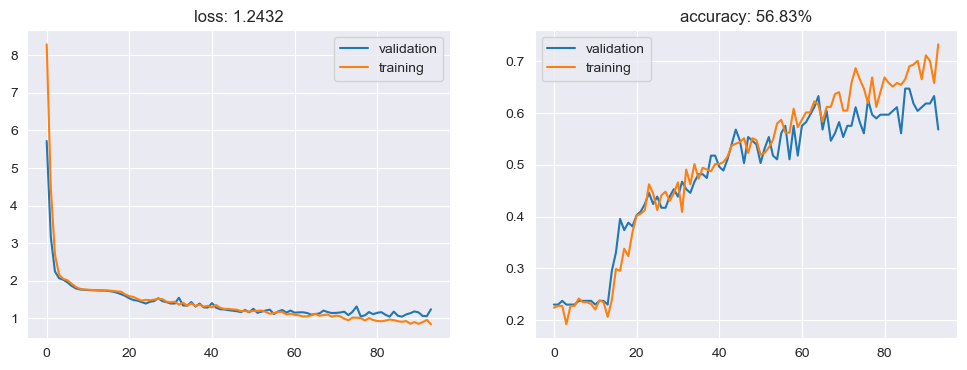

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title("loss: {:.4f}".format(history.history["val_loss"][-1]))
ax1.plot(history.history["val_loss"], label="validation")
ax1.plot(history.history["loss"], label="training")
ax1.legend()

# plot accuracy values
ax2.set_title("accuracy: {:.2f}%".format(history.history["val_accuracy"][-1] * 100))
ax2.plot(history.history["val_accuracy"], label="validation")
ax2.plot(history.history["accuracy"], label="training")
ax2.legend()

plt.show()

The reason we chose to keep with this model was that after 30 epochs performance was increasing with only little signs of overfitting with good validation accuracy (compared to other results achieved by us)

With other parameters we had sometimes clear under or overfitting (even if performance was close with 50-55% accuracy)

## Confusion matrix

In [5]:
test_preds = model.predict(test_set)

# Compute confusion matrix
matrix = confusion_matrix(
    y_true=test_set.classes,
    y_pred=test_preds.argmax(axis=1),
)

# Format as a DataFrame
class_names = list(test_set.class_indices.keys())
matrix_df = pd.DataFrame(data=matrix, columns=class_names, index=class_names)
matrix_df.columns.name = "Predictions"
matrix_df.index.name = "True class"
matrix_df

Predictions,bike,car,motorcycle,other,truck,van
True class,,,,,,
bike,11,0,1,0,0,0
car,0,7,1,1,2,0
motorcycle,1,0,7,0,1,0
other,1,0,1,3,1,0
truck,0,1,0,0,6,0
van,0,0,2,0,6,2


In [6]:
test_loss, test_acurracy = model.evaluate(test_set)
print("Test loss: {:.2f}, accuracy: {:.2f}%".format(test_loss, test_acurracy * 100))

2/2 [==============================] - 0s 76ms/step - loss: 1.1805 - accuracy: 0.6545
Test loss: 1.18, accuracy: 65.45%


## Looking at incorrectly classified images

In [10]:
from IPython.display import display

# Make predictions on test set
test_preds = model.predict(test_set)
proba_df = pd.DataFrame(test_preds, columns=class_names)

# Get predicted labels and class probabilities
pred_labels = test_preds.argmax(axis=1)

# Adding True Label vs Predict Label
true_labels = test_set.labels
proba_df['True Label'] = true_labels
proba_df['Predicted label'] = pred_labels
proba_df

# Find indices of images where predicted label is not equal to true label
incorrect_indices = np.where(pred_labels != true_labels)[0]
incorrect_indices.shape

(19,)

We average around approx half of test images that are incorrectly classified.

In [11]:
test_images = np.concatenate((test_set[0][0], test_set[1][0]), axis=0)
test_images.shape

(55, 256, 256, 3)

Plotting first 15 incorrectly classified images with their associated probabilities.

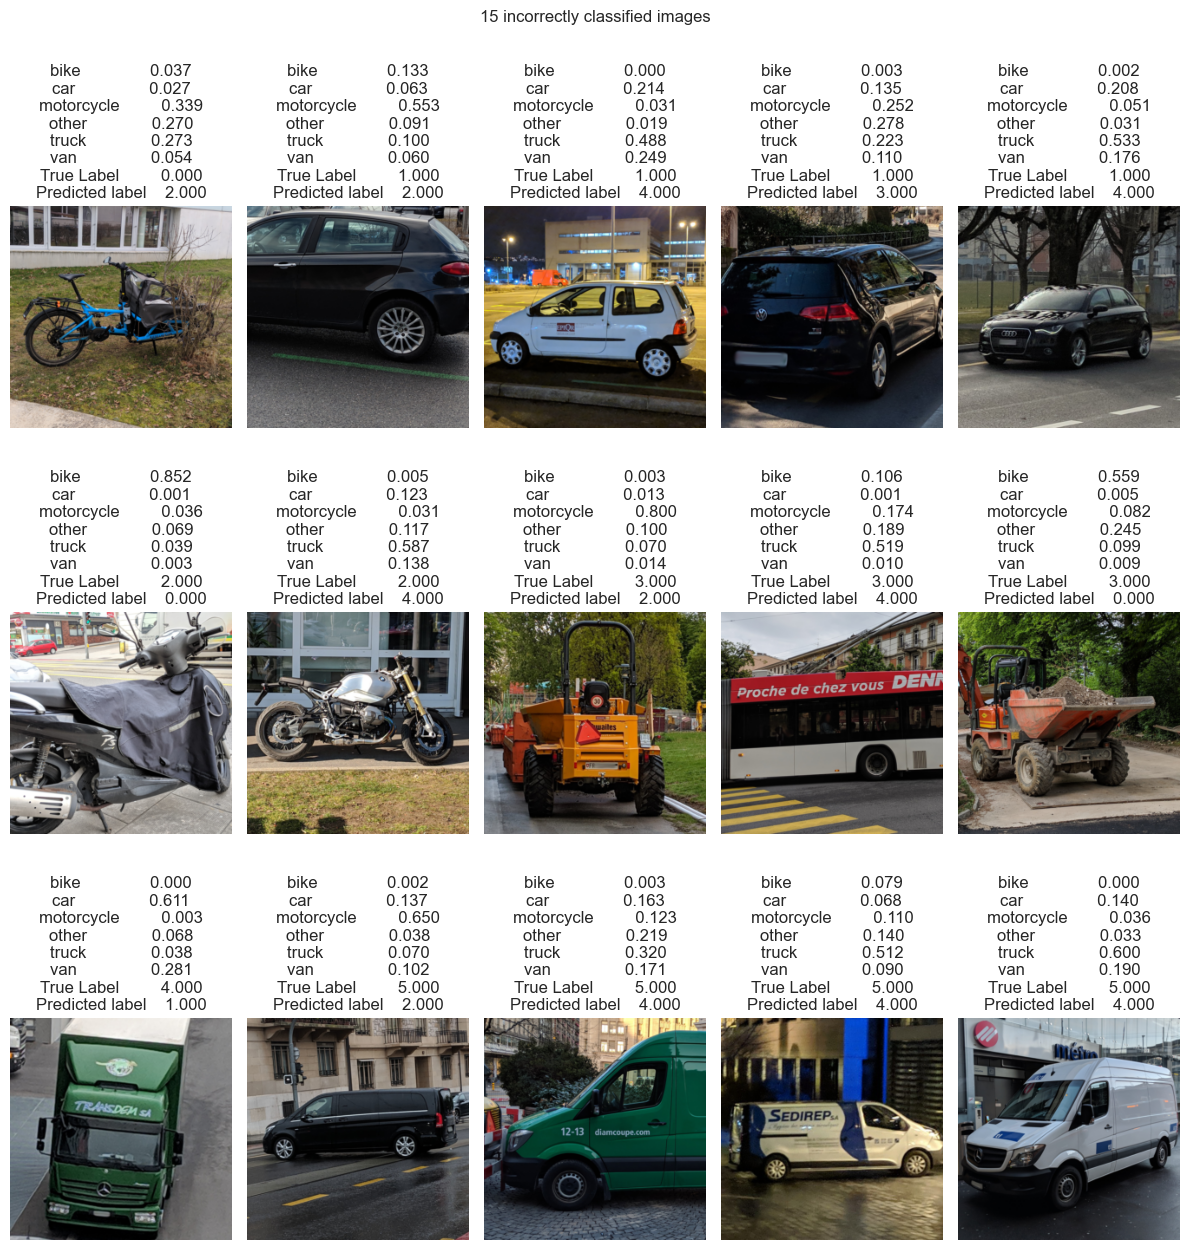

In [15]:
fig, axes = plt.subplots(3, 5, figsize=(12, 13))

for i, ax in enumerate(axes.flatten()):
    idx = incorrect_indices[i]
    image = test_images[idx]
    
    # Display image with title that includes true label, predicted label, and class probability
    confidence_title = proba_df.iloc[idx].map('{:,.3f}'.format).to_string()

    ax.imshow(image)
    ax.set_title(confidence_title)
    ax.axis('off')
    
plt.tight_layout()
plt.suptitle("15 incorrectly classified images", y=1.02)

plt.show()

## Conclusion on Convolutional Networks

We are far from reproducing performance using transfer learning. It really is a display of how better transfer learning results can be and the time savings associated.